In [33]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sksurv.ensemble import RandomSurvivalForest 
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import  make_pipeline
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns
from scipy.stats import ttest_ind

In [6]:
train_dl_p = pd.read_csv('./cli_radi_morphology_3d_DL_pphase_train_id__std.csv')
test_dl_p = pd.read_csv('./cli_radi_morphology_3d_DL_pphase_test_id__std.csv')
train_p = pd.read_csv('../OP_clinical+radiomics+3d survival/data/cli_radi_morphology_3d_train_pphase_id.csv')
test_p = pd.read_csv('../OP_clinical+radiomics+3d survival/data/cli_radi_morphology_3d_test_pphase_id.csv')

In [11]:

columns_to_merge = ['ISDnumber','p_counts','p_volume','p_surface_area','p_equivalent_diameter','p_extent','p_principal_axis_length_1','p_principal_axis_length_2',
                    'p_principal_axis_length_3','p_quaternion_w','p_quaternion_x','p_quaternion_y','p_quaternion_z','p_euler_roll','p_euler_pitch','p_euler_yaw','p_eccentricity',
                    'p_solidity','p_convex_volume','p_convex_area','p_convexity','p_compactness','p_rectangularity','p_elongation','p_sphericity_roundness',	
                    'p_area_volume_ratio','p_aspect_ratio_1','p_aspect_ratio_2','p_aspect_ratio_3','p_max_radius','p_abb_volume','p_sphericity_ellipticity',	
                    'p_defect_ratio','p_gauss_curv_mean','p_mean_curv_mean'
]

# 使用 merge 函數根據 'ISDnumber' 合併
df_merged = pd.merge(train_dl_p, train_p[columns_to_merge], on='ISDnumber', how='left')
df_merged_test = pd.merge(test_dl_p, test_p[columns_to_merge], on='ISDnumber', how='left')
# 查看合併後的結果
print(df_merged)
df_merged.to_csv('cli_radi_morphology_3d_DL_pphase_train_id__std_v2.csv',index=False)
df_merged_test.to_csv('cli_radi_morphology_3d_DL_pphase_test_id__std_v2.csv',index=False)

     Tumor size     lnAST      BCLC  Tumor number  ALBIgrade  \
0     -0.776116  1.046350 -0.272983      1.008003   1.355771   
1     -0.646299 -0.351106 -0.272983     -0.357679   1.355771   
2     -0.178961  0.409580  1.276379      1.008003  -0.722418   
3      1.638466 -0.351106  1.276379      1.008003  -0.722418   
4      0.028745 -0.351106 -0.272983     -0.357679  -0.722418   
..          ...       ...       ...           ...        ...   
402   -0.646299  1.820518 -0.272983     -0.357679   1.355771   
403   -0.230887 -2.102175 -0.272983     -0.357679  -0.722418   
404   -1.087674  0.445648 -1.822345     -0.357679  -0.722418   
405   -0.438593 -0.526850 -0.272983     -0.357679  -0.722418   
406   -0.698226  0.134376 -0.272983     -0.357679  -0.722418   

     class_Histologic grade  class_AFP     Ishak  Steatosis grade         K  \
0                 -1.593068   0.434166  1.409544        -0.811318 -1.261013   
1                 -1.593068  -1.093903  1.409544         0.881138 -0.1681

對latent features 做lasso

In [53]:
pphase_train = pd.read_csv('./only_pphase_data/pphase_latent_test_std_id.csv')

In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso

pphase_features = pphase_train.drop(columns=['ISDnumber', 'Early recur', 'Early RFS'])
# Step 1: 取得交集，確保只保留selected_features列表中存在的特徵欄位

target_variable = pphase_train['Early recur']
# Step 2: 定義Lasso模型並進行特徵篩選
lasso_model = Lasso(alpha=0.01)  # 設定Lasso模型的alpha值，這是控制稀疏性的參數
lasso_model.fit(pphase_features, target_variable)  # 假設target_variable是你的目標變數

# Step 3: 取得篩選後的特徵欄位和對應的係數
selected_features_after_lasso = pphase_features.columns[lasso_model.coef_ != 0]
coefficients = pd.Series(lasso_model.coef_[lasso_model.coef_ != 0], index=selected_features_after_lasso)

# Step 4: 將篩選後的結果存入新的DataFrame或可視化
filtered_radiomics_df = pphase_features[selected_features_after_lasso]
filtered_radiomics_df['coefficients'] = coefficients

# 現在，filtered_radiomics_df包含篩選後的特徵欄位和相應的係數
print(len(selected_features_after_lasso))
print(selected_features_after_lasso)

34
Index(['p_d3a0_cluster_prominence', 'Hu-4-P', 'p_d1a0_sum_variance',
       'p_d1a0_inverse_difference_moment_norm', 'Entropy-P',
       'p_Wavelet_bior_Vertical_bior3.9_E0', 'p_Wavelet_db_Horizontal_4_E0',
       'p_Wavelet_bior_Diagonal_bior3.7_E0',
       'p_Wavelet_bior_Vertical_bior3.1_E0', 'out_mean-P', 'mean_diff-P',
       'Sphericity-P', 'Extent-P', 'Aspect_ratio-P', 'Bending Energy-P', '11',
       '28', '34', '78', '90', '97', 'p_surface_area',
       'p_principal_axis_length_2', 'p_quaternion_w', 'p_quaternion_x',
       'p_quaternion_y', 'p_quaternion_z', 'p_euler_roll', 'p_euler_yaw',
       'p_convexity', 'p_compactness', 'p_sphericity_roundness',
       'p_aspect_ratio_1', 'p_gauss_curv_mean'],
      dtype='object')


C:\Users\User\AppData\Local\Temp\ipykernel_13852\3693797214.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_radiomics_df['coefficients'] = coefficients


In [12]:
pphase_train_lasso = pphase_train[['11', '28', '29', '34', '41', '64', '72', '86', '90', '97','ISDnumber', 'Early recur', 'Early RFS']]
pphase_train_lasso.head()
pphase_train_lasso.to_csv('./only_pphase_data/pphase_latent_train_std_id_lasso.csv',index=False)

建模

In [73]:
train = pd.read_csv('./only_pphase_data/cli_radi_morphology_3d_DL_pphase_train_id__std_v2.csv')
test = pd.read_csv('./only_pphase_data/cli_radi_morphology_3d_DL_pphase_test_id__std_v2.csv')
display(train.head())

,Tumor size,lnAST,BCLC,Tumor number,ALBIgrade,class_Histologic grade,class_AFP,Ishak,Steatosis grade,K,...,p_aspect_ratio_3,p_max_radius,p_abb_volume,p_sphericity_ellipticity,p_defect_ratio,p_gauss_curv_mean,p_mean_curv_mean,ISDnumber,Early recur,Early RFS
0,-0.776116,1.046350,-0.272983,1.008003,1.355771,-1.593068,0.434166,1.409544,-0.811318,-1.261013,...,0.000400,-0.907654,-0.444759,0.072566,-1.188204,-0.861883,-0.555623,1097,1,7.13
1,-0.646299,-0.351106,-0.272983,-0.357679,1.355771,-1.593068,-1.093903,1.409544,0.881138,-0.168100,...,0.036375,-0.819911,-0.433505,0.258073,-0.790916,-0.282073,-1.230638,497,1,13.13
2,-0.178961,0.409580,1.276379,1.008003,-0.722418,1.702934,-0.075191,0.384439,-0.811318,0.924812,...,-0.277282,0.480483,-0.111605,-0.543765,1.699326,-0.266912,0.171359,381,0,24.00
3,1.638466,-0.351106,1.276379,1.008003,-0.722418,0.604267,-0.075191,-1.665771,-0.811318,1.361977,...,0.665021,0.674880,0.339951,0.060598,-1.109654,-0.354032,0.451480,1089,1,12.27
4,0.028745,-0.351106,-0.272983,-0.357679,-0.722418,-1.593068,-0.075191,-0.128114,-0.811318,0.050482,...,-0.354149,-0.114142,-0.326579,1.915927,-0.409284,0.487942,-0.554013,350,0,24.00


In [3]:
# import pandas as pd
# from scipy.stats import ttest_ind

# # 檢查兩個資料表的欄位是否相同，如果不同則無法進行p-value分析
# if set(train.columns) != set(test.columns):
#     raise ValueError("兩個資料表的欄位不相同，無法進行p-value分析。")

# # 初始化一個空的DataFrame來保存p-value結果
# result_df = pd.DataFrame(columns=['欄位名稱', 'p-value'])

# # 對每個欄位進行p-value分析
# for column in train.columns:
#     # 使用ttest_ind進行獨立樣本t檢定，前提是這個欄位的值是連續型數據
#     p_value = ttest_ind(train[column], test[column]).pvalue
    
#     # 判斷是否有顯著差異（通常設定alpha值為0.05）
#     if p_value < 0.05:
#         result_df = pd.concat([result_df, pd.DataFrame({'欄位名稱': [column], 'p-value': [p_value]})], ignore_index=True)

# # 輸出有顯著差異的欄位
# print("有顯著差異的欄位：")
# print(result_df)

In [72]:
# import pandas as pd
# train = pd.read_csv('./only_pphase_data/pphase_latent_test_std_id.csv')
# # 創建一個空的 DataFrame 來存儲結果
# result_df = pd.DataFrame(columns=['Column', 'p-value'])

# # 迭代資料集的每個欄位
# for column in train.columns:
#     # 使用 t-test 計算 p-value
#     _, p_value = ttest_ind(train[column], train['Early recur'])
#     #
#     # 將結果添加到結果 DataFrame 中
#     result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 'p-value': [p_value]})], ignore_index=True)
# # 將結果按照 p-value 由小到大排序
# result_df = result_df.sort_values(by='p-value')

# # 重設索引以便結果 DataFrame 的索引是連續的
# result_df = result_df.reset_index(drop=True)
# # 印出結果 DataFrame
# print(result_df)
# result_df = result_df[:30]
# result_df.to_csv('C:/Users/User/Desktop/test.csv',index=False)


          Column       p-value
0      Early RFS  1.082966e-90
1      ISDnumber  1.311889e-48
2             28  7.192882e-15
3       p_counts  2.004804e-14
4             34  1.030578e-13
..           ...           ...
155            5  5.214854e-02
156           86  7.901141e-02
157            6  8.039537e-02
158           97  1.871553e-01
159  Early recur  1.000000e+00

[160 rows x 2 columns]


In [5]:
# import pandas as pd
# from scipy.stats import mannwhitneyu

# # Create an empty DataFrame to store results
# result_df = pd.DataFrame(columns=['Column', 'p-value'])

# # Iterate over each column in the train dataset
# for column in train.columns:
#     # Calculate p-value using the Mann-Whitney U test
#     _, p_value = mannwhitneyu(train[column], train['Early recur'])
    
#     # Append results to the result DataFrame
#     result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 'p-value': [p_value]})], ignore_index=True)

# # Sort results by p-value in ascending order
# result_df = result_df.sort_values(by='p-value')

# # Reset index for continuous indexing
# result_df = result_df.reset_index(drop=True)

# # Select top 70 columns with smallest p-values
# top_70_train_columns = result_df['Column'][:70]

# # Print top 70 train columns
# print("Top 70 train columns:")
# print(top_70_train_columns)

# # Write results to a CSV file
# top_70_train_columns.to_csv('./pvalue/train_utest.csv', index=False)

# # Reset result_df for the test dataset
# result_df = pd.DataFrame(columns=['Column', 'p-value'])

# # Iterate over each column in the test dataset
# for column in test.columns:
#     # Calculate p-value using the Mann-Whitney U test
#     _, p_value = mannwhitneyu(test[column], test['Early recur'])
    
#     # Append results to the result DataFrame
#     result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 'p-value': [p_value]})], ignore_index=True)

# # Sort results by p-value in ascending order
# result_df = result_df.sort_values(by='p-value')

# # Reset index for continuous indexing
# result_df = result_df.reset_index(drop=True)

# # Select top 70 columns with smallest p-values
# top_70_test_columns = result_df['Column'][:70]

# # Print top 70 test columns
# print("\nTop 70 test columns:")
# print(top_70_test_columns)

# # Write results to a CSV file
# top_70_test_columns.to_csv('./pvalue/test_utest.csv', index=False)


In [6]:
# train_top_30 = pd.read_csv('./pvalue/train_utest.csv')
# test_top_30 = pd.read_csv('./pvalue/test_utest.csv')

# # 使用 set.intersection() 找到兩個 CSV 檔案中的交集欄位名稱
# common_columns = set(train_top_30['Column']).intersection(test_top_30['Column'])

# # 轉換為列表
# common_columns_list = list(common_columns)

# # 印出共同的欄位名稱
# print("共同的欄位名稱:")
# print(common_columns_list)

共同的欄位名稱:
['ISDnumber', 'n_d4a45_dissimilartiy', 'n_d5a45_correlation', 'in_std-A', 'Compactness-A', 'a_d2a0_cluster_prominence', 'n_convex_area', 'n_gauss_curv_mean', 'n_d4a90_correlation', 'Hu-6-N', 'n_aspect_ratio_3', 'BMI', 'n_rectangularity', 'mean_diff-P', 'AST', 'n_principal_axis_length_2', 'n_equivalent_diameter', 'Convex_perimeter-N', 'Hu-1-A', 'Hu-0-A', 'n_principal_axis_length_1', 'n_aspect_ratio_2', 'MaxPixelValue-N', 'n_d1a90_autocorrelation', 'Tumor number', 'n_quaternion_x', 'n_quaternion_y', 'n_solidity', 'n_area_volume_ratio', 'class_Histologic grade', 'mean_diff-N', 'BCLC', 'Aspect_ratio-P', 'n_volume', 'n_euler_roll', 'Hu-1-P', 'n_convex_volume', 'Tumor size', 'n_principal_axis_length_3', 'n_d2a90_dissimilartiy', 'n_quaternion_w', 'n_extent', 'n_max_radius', 'n_sphericity_ellipticity', 'n_quaternion_z', 'n_abb_volume', 'n_counts', 'Hu-2-N', 'Steatosis grade', 'n_surface_area', 'Early RFS']


In [3]:
selected = ['Tumor size', 'a_Wavelet_rbior_Diagonal_rbio1.5_E0', 'Convex_perimeter-N',
 'a_Wavelet_rbior_Diagonal_rbio3.3_E0', 'BCLC', 'Tumor number', 'MVI','MaxPixelValue-N', 'n_Wavelet_bior_Vertical_bior3.1_E0'
 ,'p_Wavelet_bior_Vertical_bior3.1_E0', 'AI_Morphology_score', 'Skewness-N', 'class_Histologic grade', 'lnAST',
   'class_AFP', 'Steatosis grade', 'p_Wavelet_db_Horizontal_4_E0', 'ALBIgrade', 'K', 'AST', 'AI_Morphology_score_classification'
, 'p_Wavelet_fk_Vertical_fk6_E0', 'Ishak', 'n_Wavelet_rbior_Vertical_rbio3.3_E0'
,'n_eccentricity','n_compactness','n_euler_pitch','n_counts','n_quaternion_x','n_abb_volume','n_quaternion_w'
,'n_aspect_ratio_3','n_convex_volume',
'28','34','11','7','79','77','36','4','75','n_d2a90_dissimilartiy','n_d4a45_dissimilartiy'
,'p_d4a0_info_measure_corr_2','p_d2a45_correlation','a_d5a135_correlation', 'Hu-1-P','Hu-2-N','Hu-6-A'
]#radiomics model final features

'p_d3a0_cluster_prominence', 'Hu-4-P', 'p_d1a0_sum_variance',
       'p_d1a0_inverse_difference_moment_norm', 'Entropy-P',
       'p_Wavelet_bior_Vertical_bior3.9_E0', 'p_Wavelet_db_Horizontal_4_E0',
       'p_Wavelet_bior_Diagonal_bior3.7_E0',
       'p_Wavelet_bior_Vertical_bior3.1_E0', 'out_mean-P', 'mean_diff-P',
       'Sphericity-P', 'Extent-P', 'Aspect_ratio-P', 'Bending Energy-P', '11',
       '28', '34', '78', '90', '97', 'p_surface_area',
       'p_principal_axis_length_2', 'p_quaternion_w', 'p_quaternion_x',
       'p_quaternion_y', 'p_quaternion_z', 'p_euler_roll', 'p_euler_yaw',
       'p_convexity', 'p_compactness', 'p_sphericity_roundness',
       'p_aspect_ratio_1', 'p_gauss_curv_mean'

In [208]:
selected = ['Tumor size', 'Radii-P' ,'p_d2a45_correlation', 'class_AFP',
 'p_d3a0_cluster_prominence', 'Tumor number', 'lnAST',
 'p_sphericity_roundness' ,'p_volume', '28', 'ALBIgrade', 'p_elongation', 'MVI',
 'Sphericity-P' ,'p_Wavelet_fk_Vertical_fk6_E0', 'p_rectangularity',
 'class_Steatosis grade' ,'Ishak', '86' ,'BCLC', 'mean_diff-P',
 'Bending Energy-P' ,'p_d4a0_info_measure_corr_2', '72',
 'class_Histologic grade' ,'p_d1a0_inverse_difference_moment_norm',
 'Entropy-P', 'p_surface_area', 'Steatosis grade', 'HBsAg', 'p_solidity',
 'p_eccentricity' ,'p_aspect_ratio_1', 'K','AST','BMI' ,
 'p_counts','Hu-4-P',
]#只有P相位的特徵


In [209]:
X = train[ selected ]
y_struct = train[['Early recur','Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])


In [210]:
coxnet = CoxnetSurvivalAnalysis()
coxnet.fit(X, y_struct)
print("fitted.")

fitted.


In [211]:
preds_train = coxnet.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

#concordance_index_ipcw((censored_test, survival_test, preds ))

(0.7951762084130396, 40321, 10386, 0, 5)

In [212]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(train['Early recur'] > 0, preds_train)
print("AUC:", auc)

AUC: 0.8335362142422398


In [213]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]


In [214]:
y_struct_test = test[['Early recur', 'Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [215]:
preds = coxnet.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)
#concordance_index_ipcw(y_struct,y_struct_test , preds)

(0.7268030366933783, 6893, 2591, 0, 1)

In [216]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test['Early recur'] > 0, preds)
print("AUC:", auc)

AUC: 0.7583638087498308


In [18]:
# 將模型保存到文件
# joblib.dump(coxnet, './result/OP_post_2year_coxnet_model_cli_radi_morphology_3d_DL_nphase.joblib')

['./result/OP_post_2year_coxnet_model_cli_radi_morphology_3d_DL_nphase.joblib']

合併回大表

In [17]:

# # 将预测结果添加到原始数据框中
# train['Predicted_Survival_train'] = preds_train
# test['Predicted_Survival_test'] = preds
# train['high_low_risk_train'] = train['Predicted_Survival_train'].apply(lambda x: 1 if x > 0 else 0)
# test['high_low_risk_test'] = test['Predicted_Survival_test'].apply(lambda x: 1 if x > 0 else 0)
# # 输出包含预测结果的数据到CSV文件
# train.to_csv('./cli_radi_morphology_3d_DL_nphase_train_id_predict.csv', index=False)
# test.to_csv('./cli_radi_morphology_3d_DL_nphase_test_id_predict.csv', index=False)

In [29]:
# raw = pd.read_csv('../202231011給李醫師資料整理/HCC OP+RFA 20230511 n=2261 去名化.csv')
# train = pd.read_csv('./cli_radi_morphology_3d_DL_nphase_train_id_predict.csv')
# test = pd.read_csv('./cli_radi_morphology_3d_DL_nphase_test_id_predict.csv')
# # train.rename(columns={'ISDnumber': 'ID'}, inplace=True)
# # test.rename(columns={'ISDnumber': 'ID'}, inplace=True)

# df_merged = pd.merge(raw, train[['ISD number', 'Predicted_Survival_train','high_low_risk_train']], on='ISD number', how='left')
# raw['Predicted_Survival_DL_train'] = df_merged['Predicted_Survival_train']
# raw['high_low_risk_DL_train'] = df_merged['high_low_risk_train']

# df_merged = pd.merge(raw, test[['ISD number', 'Predicted_Survival_test','high_low_risk_test']], on='ISD number', how='left')
# raw['Predicted_Survival_DL_test'] = df_merged['Predicted_Survival_test']
# raw['high_low_risk_DL_test'] = df_merged['high_low_risk_test']

# raw['Predicted_Survival_DL'] = raw['Predicted_Survival_DL_train'].combine_first(
#     raw['Predicted_Survival_DL_test'])
# raw['high_low_risk_DL'] = raw['high_low_risk_DL_train'].combine_first(
#     raw['high_low_risk_DL_test'])
# print(raw.head())

   Treatment     ID ISD number  20230511 OP_NAP  20230511 RFA_NAP  Milan_out  \
0          1  10001        315              1.0               NaN          0   
1          1  10002        352              1.0               NaN          1   
2          1  10003        398              1.0               NaN          1   
3          1  10004        418              1.0               NaN          1   
4          1  10005        423              1.0               NaN          1   

     Age  Sex  Recur  Recur_date  ... HBV DNA (IU/ml)  GARSL RFA_risk_score  \
0  35.65    2      0  2022/10/28  ...             NaN    0.0            NaN   
1  58.10    1      1   2016/9/20  ...             NaN    1.0            NaN   
2  64.44    1      1   2019/1/21  ...             NaN    0.0            NaN   
3  62.56    1      1    2018/3/2  ...             NaN    1.0            NaN   
4  52.90    1      1   2018/3/30  ...             NaN    1.0            NaN   

   RFA_risk_class2  Predicted_Survival_DL_tr

In [30]:
# raw.to_csv('./HCC OP+RFA 20230511 n=2261 去名化_加入DL的模型預測結果.csv',index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


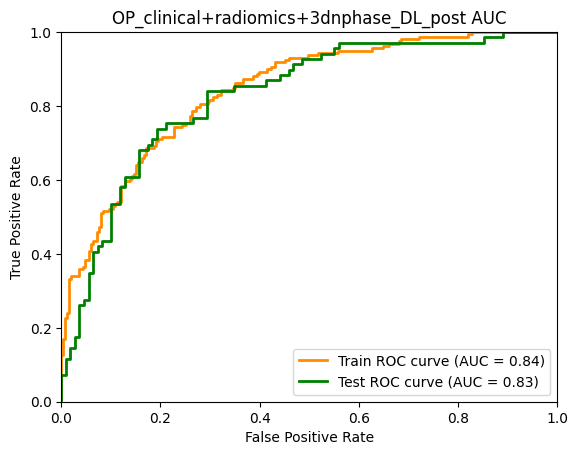

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# ...（您的其餘程式碼）

# 計算訓練集的AUC和繪製ROC曲線
fpr_train, tpr_train, thresholds_train = roc_curve(train['Early recur'] > 0, preds_train)
auc_train = roc_auc_score(train['Early recur'] > 0, preds_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)

# 計算測試集的AUC和繪製ROC曲線
fpr_test, tpr_test, thresholds_test = roc_curve(test['Early recur'] > 0, preds)
auc_test = roc_auc_score(test['Early recur'] > 0, preds)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)

# 繪製ROC曲線
# plt.figure(figsize=(8, 6))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OP_clinical+radiomics+3dnphase_DL_post AUC')
plt.legend(loc="lower right")
# plt.grid()
# plt.savefig('./result/OP_clinical+radiomics+3dnphase_post AUC.png')
plt.show()


畫KMplot

In [21]:
test_low = test[ preds < 0 ]
# test_med = test[ (preds > -0.29) & (preds <0.55) ]
test_high = test[ preds >= 0 ]

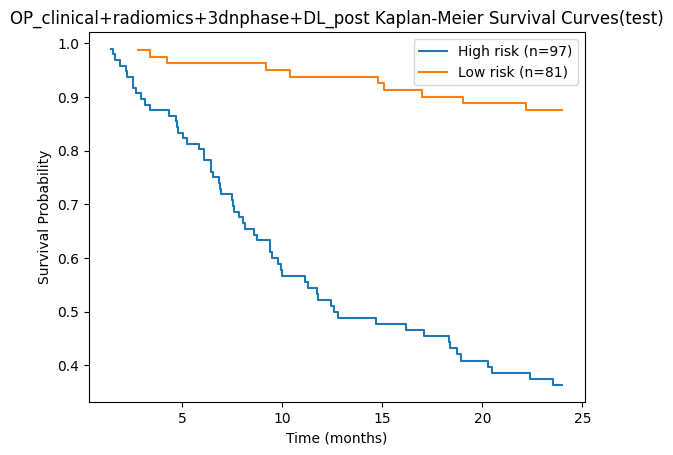

In [22]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')


time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('OP_clinical+radiomics+3dnphase+DL_post Kaplan-Meier Survival Curves(test)')
plt.legend()
# plt.savefig('./result/OP_clinical+radiomics+3dnphase_post kmplot high low (OP_clinical_post).png')
plt.show()


In [41]:
display(train.head())

,Tumor size,lnAST,BCLC,Tumor number,ALBIgrade,class_Histologic grade,class_AFP,Ishak,Steatosis grade,K,...,95,96,97,98,99,dv0,dv1,ISDnumber,Early recur,Early RFS
0,-0.776116,1.046350,-0.272983,1.008003,1.355771,-1.593068,0.434166,1.409544,-0.811318,-1.261013,...,0.548219,0.344955,-0.882156,-0.485201,0.436020,0.470333,-0.470334,1097.0,1.0,7.13
1,-0.646299,-0.351106,-0.272983,-0.357679,1.355771,-1.593068,-1.093903,1.409544,0.881138,-0.168100,...,-1.549372,-1.713890,0.642984,1.706940,-1.643543,-1.643334,1.643333,497.0,1.0,13.13
2,-0.178961,0.409580,1.276379,1.008003,-0.722418,1.702934,-0.075191,0.384439,-0.811318,0.924812,...,0.575953,0.269095,-1.461391,-0.377761,0.437109,0.380727,-0.380727,381.0,0.0,24.00
3,1.638466,-0.351106,1.276379,1.008003,-0.722418,0.604267,-0.075191,-1.665771,-0.811318,1.361977,...,-0.336238,-0.287725,0.538154,0.161972,-0.194896,-0.214757,0.214758,1089.0,1.0,12.27
4,0.028745,-0.351106,-0.272983,-0.357679,-0.722418,-1.593068,-0.075191,-0.128114,-0.811318,0.050482,...,-1.362057,-0.828437,1.932147,1.237217,-1.180422,-1.227915,1.227915,350.0,0.0,24.00


In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
test_X_std = test.drop(columns=['Early recur', 'Early RFS','ISDnumber'])
# 假設radiomics_df_raw是你的資料表，selected_features是特徵欄位的list
# 如果radiomics_df_raw是一個DataFrame，selected_features是一個列表
# 假設target_variable是你的目標變數
# 則可以透過以下程式碼進行特徵篩選：

# Step 1: 取得交集，確保只保留selected_features列表中存在的特徵欄位

target_variable = test['Early recur']
# Step 2: 定義Lasso模型並進行特徵篩選
lasso_model = Lasso(alpha=0.01)  # 設定Lasso模型的alpha值，這是控制稀疏性的參數
lasso_model.fit(test_X_std, target_variable)  # 假設target_variable是你的目標變數

# Step 3: 取得篩選後的特徵欄位和對應的係數
selected_features_after_lasso = test_X_std.columns[lasso_model.coef_ != 0]
coefficients = pd.Series(lasso_model.coef_[lasso_model.coef_ != 0], index=selected_features_after_lasso)

# Step 4: 將篩選後的結果存入新的DataFrame或可視化
filtered_radiomics_df = test[selected_features_after_lasso]
filtered_radiomics_df['coefficients'] = coefficients

# 現在，filtered_radiomics_df包含篩選後的特徵欄位和相應的係數
print(len(selected_features_after_lasso))


67


C:\Users\User\AppData\Local\Temp\ipykernel_5224\2971749964.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_radiomics_df['coefficients'] = coefficients


In [43]:
print(selected_features_after_lasso)
len(selected_features_after_lasso)

Index(['Tumor size', 'lnAST', 'BCLC', 'Tumor number', 'ALBIgrade',
       'class_Histologic grade', 'K', 'class_Steatosis grade', 'HBsAg', 'BMI',
       'MVI', 'AI_Morphology', 'Radii-P', 'Hu-4-P', 'Hu-1-P',
       'n_d1a90_autocorrelation', 'Hu-2-N', 'Hu-6-N',
       'n_d4a45_cluster_prominence', 'a_d2a0_cluster_prominence', 'in_std-A',
       'n_d2a90_dissimilartiy', 'n_d4a45_dissimilartiy',
       'n_d5a135_info_measure_corr_2', 'n_d5a45_correlation',
       'a_d5a135_correlation', 'a_d1a45_dissimilartiy',
       'a_Wavelet_rbior_Diagonal_rbio3.7_E0', 'a_Wavelet_sym_Horizontal_20_E0',
       'Entropy-P', 'n_Wavelet_rbior_Horizontal_rbio3.9_E0',
       'n_Wavelet_sym_Horizontal_13_E0', 'n_Wavelet_bior_Diagonal_bior3.3_E0',
       'n_Wavelet_rbior_Vertical_rbio3.3_E0',
       'n_Wavelet_bior_Vertical_bior3.1_E0', 'out_mean-P', 'mean_diff-P',
       'Skewness-N', 'Eccentricity-N', 'Rectangularity-N', 'Sphericity-P',
       'Extent-P', 'Eccentricity-A', 'Compactness-A', 'Aspect_ratio-P'

67

CoxPH

In [6]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X, y_struct)
print("fitted.")

fitted.


In [7]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]

In [8]:
preds_train = cph.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

(0.7654931228508909, 39181, 12003, 0, 5)

In [9]:
preds = cph.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)

(0.7633548118894201, 7345, 2277, 0, 1)

In [12]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = cph.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Early recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.808403137880601


In [16]:
# 將模型保存到文件
# joblib.dump(cph, './result/OP_post_overall_coxph_model.joblib')

['./result/OP_post_overall_coxph_model.joblib']

個人化

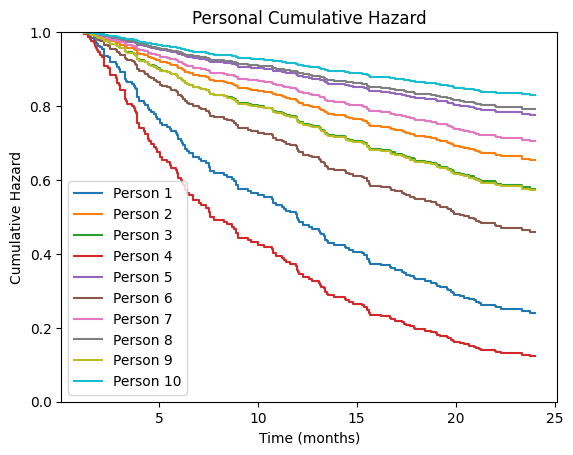

In [10]:
import matplotlib.pyplot as plt

# chf_funcs = cph.predict_cumulative_hazard_function(X.iloc[:10])
chf_funcs = cph.predict_survival_function(X.iloc[:10])


# 为每个函数设置编号作为label
for i, fn in enumerate(chf_funcs):
    plt.step(fn.x, fn(fn.x), where="post", label=f"Person {i+1}")

plt.title('Personal Cumulative Hazard')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [17]:
train['riskscore'] = coxnet.predict(X)

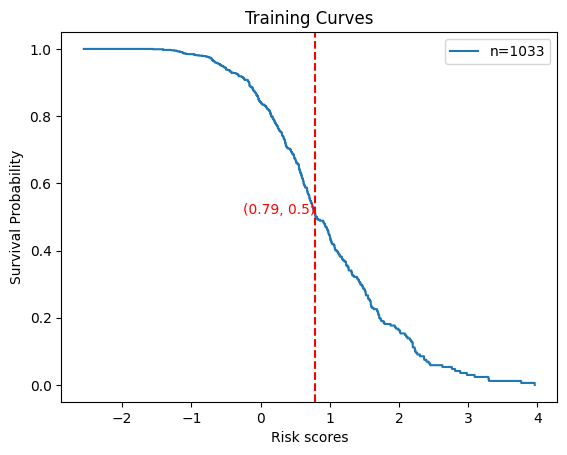

In [18]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
# time_high, survival_prob_high = kaplan_meier_estimator(test['riskscore'].astype("bool"),test['Recurrence free survival'])
time_high, survival_prob_high = kaplan_meier_estimator(train['Early recur'].astype("bool"),train['riskscore'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count = len(train)
plt.step(time_high, survival_prob_high, where="post",label=f'n={count}')
plt.xlabel('Risk scores')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Curves')
plt.legend()
# 找到 ylabel 為 0.5 的對應 xlabel 數值
ylabel_0_5 = 0.5
index = np.abs(survival_prob_high - ylabel_0_5).argmin()
xlabel_at_0_5 = time_high[index]
plt.axvline(x=xlabel_at_0_5, color='red', linestyle='--')
plt.text(xlabel_at_0_5, ylabel_0_5, f'{xlabel_at_0_5.round(2),ylabel_0_5}', color='red', ha='right', va='bottom')


plt.savefig('./result/統計圖表/OP_post_2year/Training Curves(OP_post_2year).png')
plt.show()

In [14]:
for i in range(len(test_X_std)):
    print("ID: {}, Risk Score: {}".format(test_X_std.index[i], preds[i]))

ID: 0, Risk Score: 0.15433679467914807
ID: 1, Risk Score: 1.2721895544311577
ID: 2, Risk Score: 0.5829809858311206
ID: 3, Risk Score: 0.8568001283407217
ID: 4, Risk Score: -0.2748698538050796
ID: 5, Risk Score: -0.31717280084470745
ID: 6, Risk Score: 0.6850944306854112
ID: 7, Risk Score: 0.24345287665294907
ID: 8, Risk Score: 0.2633162219068401
ID: 9, Risk Score: -0.23483023409261172
ID: 10, Risk Score: 0.2589353154906855
ID: 11, Risk Score: 0.42537400581588436
ID: 12, Risk Score: -0.10045920065274455
ID: 13, Risk Score: -0.22617813568984363
ID: 14, Risk Score: -0.1916055452949582
ID: 15, Risk Score: 0.16266127635043487
ID: 16, Risk Score: 0.9439458494173605
ID: 17, Risk Score: 0.7237598429932703
ID: 18, Risk Score: -0.05133363596236752
ID: 19, Risk Score: -0.5847901377660265
ID: 20, Risk Score: 0.19876655300486945
ID: 21, Risk Score: 0.12732731097064004
ID: 22, Risk Score: 0.002517332013693821
ID: 23, Risk Score: -0.036925538337527625
ID: 24, Risk Score: -0.4735857700305541
ID: 25, Ri

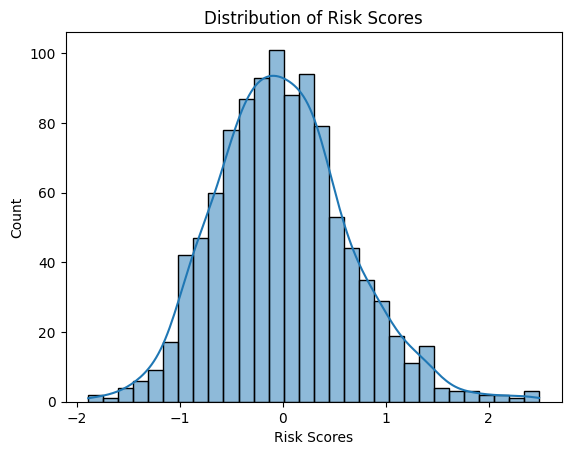

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of Risk Scores')
plt.show()

以人數30%切點切出risk score當作threshold

Threshold at 30%: -0.4244191102017738


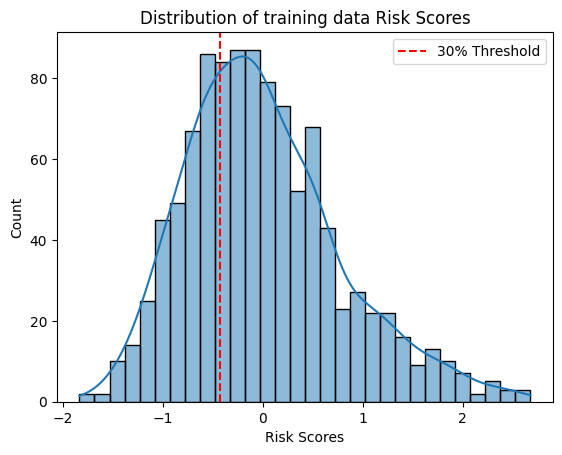

In [41]:
# 將 preds_train 由低至高排序
sorted_preds = sorted(preds_train)

# 計算第 70% 的索引位置
index_70_percent = int(0.32 * len(sorted_preds))

# 印出第 70% 的數值
threshold_70_percent = sorted_preds[index_70_percent]
print("Threshold at 30%:", threshold_70_percent)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')
plt.axvline(x=threshold_70_percent, color='red', linestyle='--', label='30% Threshold')
plt.legend()
# plt.savefig('./data_cluster/統計圖表/train1.png')
plt.show()

以train的95%信賴區間切三等份當作threshold

Cut Point 1: -1.2485442530631845
Cut Point 2: 1.8505131351420279


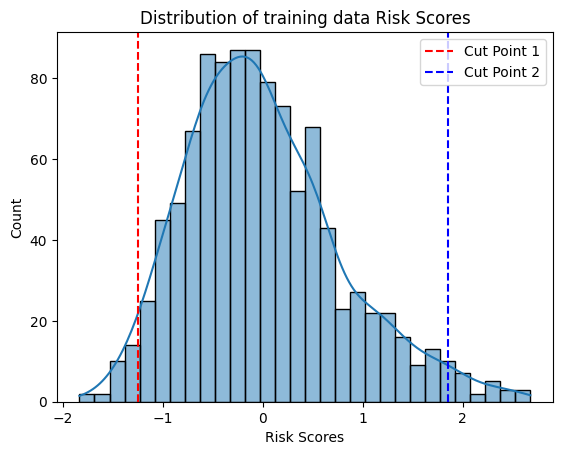

In [42]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)

# 將信賴區間分成三等分的切點
cut_points = [lower_bound, upper_bound]

# 分割資料成三個區間
low_data = preds_train[preds_train <= cut_points[0]]
medium_data = preds_train[(preds_train > cut_points[0]) & (preds_train < cut_points[1])]
high_data = preds_train[preds_train >= cut_points[1]]

# 列印切點數值
print("Cut Point 1:", cut_points[0])
print("Cut Point 2:", cut_points[1])

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_points[0], color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_points[1], color='blue', linestyle='--', label='Cut Point 2')
plt.legend()
plt.show()


Cut Point 1: -0.2924424373429265
Cut Point 2: 0.5446781970613734


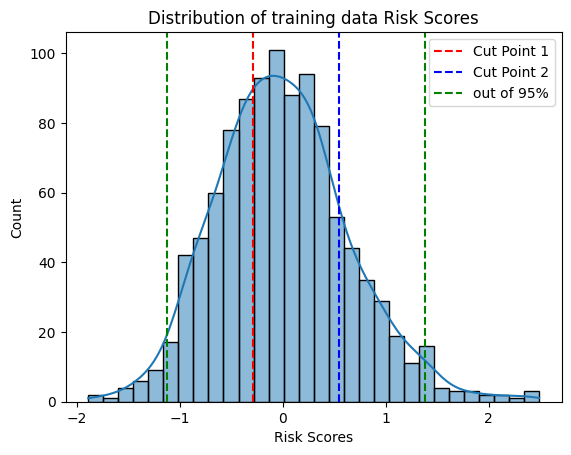

In [11]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)
cut_points = [lower_bound, upper_bound]
# 將信賴區間切成三等份的切點
cut_point1 = lower_bound + (upper_bound - lower_bound) / 3
cut_point2 = lower_bound + (upper_bound - lower_bound) * 2 / 3

# 列印切點數值
print("Cut Point 1:", cut_point1)
print("Cut Point 2:", cut_point2)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_point1, color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_point2, color='blue', linestyle='--', label='Cut Point 2')
plt.axvline(x=cut_points[0], color='green', linestyle='--', label='out of 95%')
plt.axvline(x=cut_points[1], color='green', linestyle='--')
plt.legend()
#plt.savefig('./data_cluster/統計圖表/train 95% .png')
plt.show()


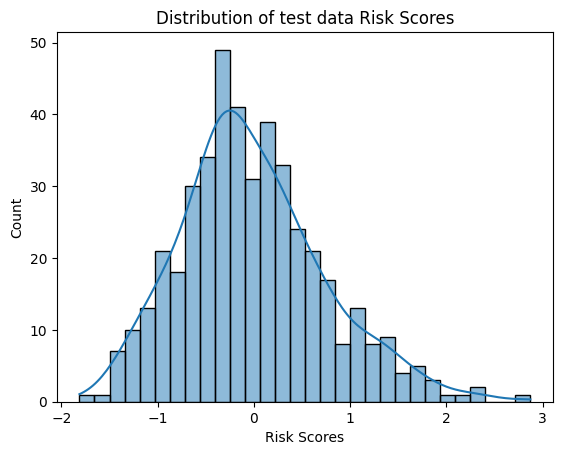

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of test data Risk Scores')
#plt.savefig('./data_cluster/統計圖表/test1.png')
plt.show()


In [12]:
train_low = train[ preds_train <=-0.29 ]
train_med = train[ (preds_train > -0.29) & (preds_train <0.55) ]
train_high = train[ preds_train >= 0.55 ]

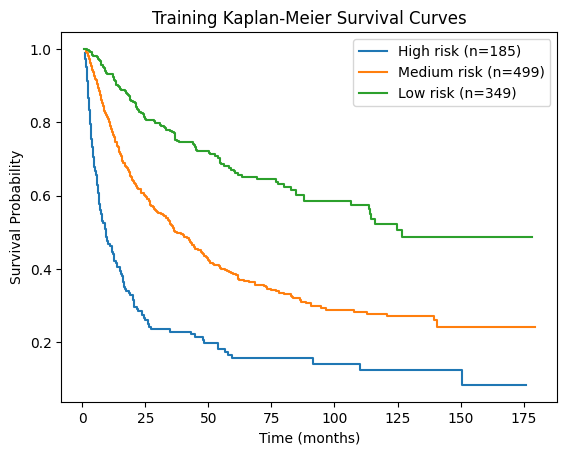

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(train_high['Recur'].astype("bool"),train_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(train_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(train_med['Recur'].astype("bool"),train_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(train_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(train_low['Recur'].astype("bool"),train_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(train_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Kaplan-Meier Survival Curves')
plt.legend()
#plt.savefig('./result/統計圖表/Training kmplot high low med(OP_post).png')
plt.show()


In [14]:
test_low = test[ preds <=-0.29 ]
test_med = test[ (preds > -0.29) & (preds <0.55) ]
test_high = test[ preds >= 0.55 ]

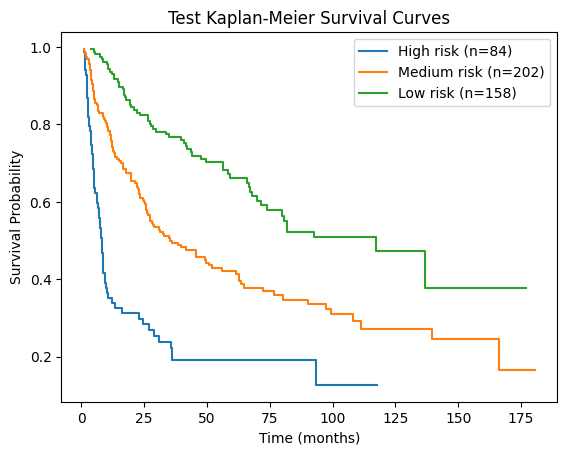

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(test_med['Recur'].astype("bool"),test_med['Recurrence free survival'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(test_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
# plt.savefig('./result/統計圖表/test kmplot high low med(OP_post).png')
plt.show()


In [31]:
test_low = test[ preds <= 0.79]
test_high = test[ preds > 0.79 ]

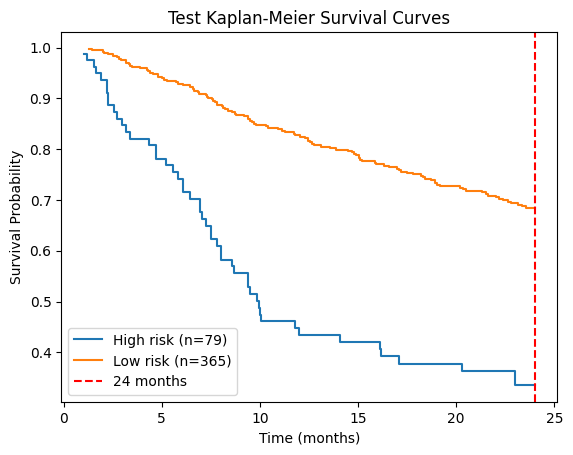

In [32]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
plt.savefig('./result/統計圖表/OP_post_2year/Test km_plot high low(OP_post_2year).png')
plt.show()


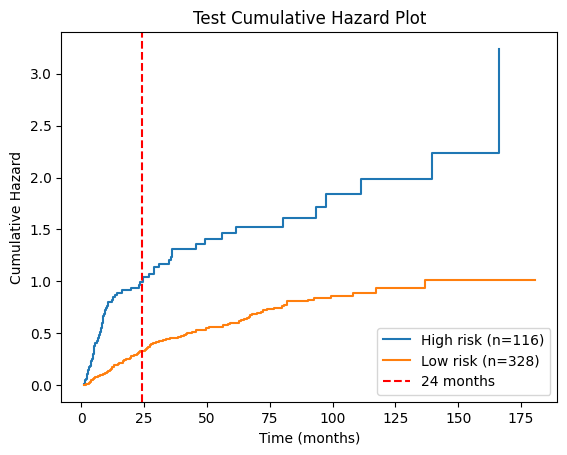

In [23]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = nelson_aalen_estimator(test_high['Recur'].astype("bool"),test_high['Recurrence free survival'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = nelson_aalen_estimator(test_low['Recur'].astype("bool"),test_low['Recurrence free survival'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
# 設定圖表的標題
plt.title('Test Cumulative Hazard Plot')
plt.legend()
plt.savefig('./result/統計圖表/Test Cumulative Hazard Plot high low(OP_post).png')
plt.show()


建立非線性模型

In [23]:
train = pd.read_csv('./data/RFA_lnV2_noISD_train_0419_std.csv')
test = pd.read_csv('./data/RFA_lnV2_noISD_test_0419_std.csv')

In [24]:
selected = ['lnPLAT','CR' ,'APRI' ,'FIB4' ,'BUN', 'Tumor size' ,'PTINR' ,'lnALT','Child_Class','AFP' ,'Weight']#gen=100 conv_gen=30 survtree

In [25]:
X = train[ selected ]
y_struct = train[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [26]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

SurvivalTree

In [27]:
from sksurv.tree import SurvivalTree

estimator = SurvivalTree().fit(X, y_struct)

preds = estimator.predict(test_X_std)

concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)


(0.5157909381811436, 10834, 10153, 576, 1)

In [29]:
preds = estimator.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds)

(0.8682501376010838, 102287, 15310, 498, 25)

RandomSurvivalForest

In [47]:
combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index

Int64Index([  0,   2,   4,   5,   8,   9,  10,  11,  13,  14,
            ...
            137, 138, 139, 140, 142, 143, 144, 146, 147, 149],
           dtype='int64', length=355)

<AxesSubplot: ylabel='Count'>

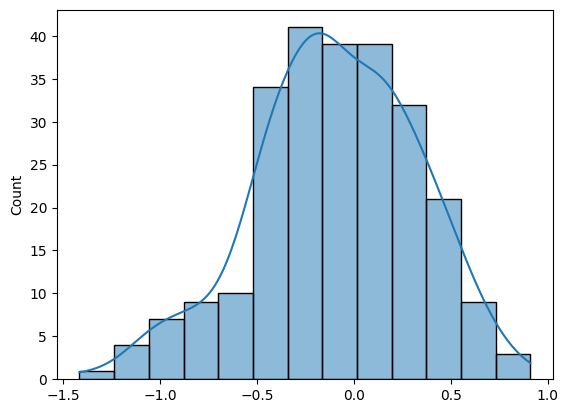

In [53]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==0)  ].index ], kde=True)

<AxesSubplot: ylabel='Count'>

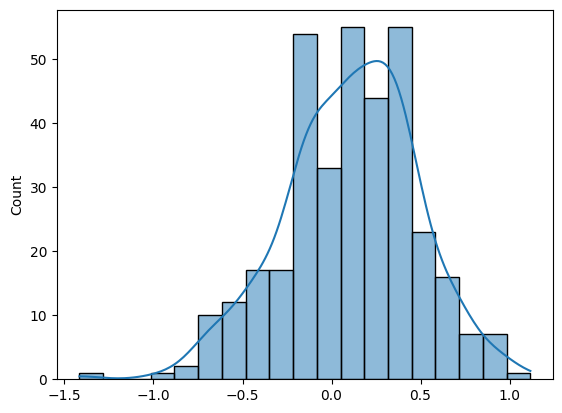

In [51]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index ], kde=True)